# TTV Retrieval for Kepler-51

This notebook is the exact same as 'kepler-51.ipynb', but here we're testing the use of parallel proccessing (through dynesty).

In this notebook, we will perform a dynamical retrieval for Kepler-51 = KOI-620. This is a system with three "super-puffs," planets with anomalously small densities, first analyzed by Masuda (2014). Hopefully, a three-planet system won't be too complex for us to handle. First, let's import packages and import data from the latest analysis of this system by Libby-Roberts et al. (2020):

In [1]:
%matplotlib inline
import ttvnest
import numpy as np
from multiprocess import Pool

data = []
errs = []
epochs = []

#reading in from Libby-Roberts+20
fnames = ['k51b.txt', 'k51c.txt', 'k51d.txt']
def read_data(fname):
    dat = np.loadtxt(fname, skiprows = 5)
    tempdat = np.array(dat[:,1], dtype = 'float')
    tempep = np.array(dat[:,0], dtype = 'int')
    temperr = np.maximum(np.array(dat[:,2], dtype = 'float'), np.array(dat[:,3], dtype = 'float'))
    return tempdat, temperr, tempep

for fname in fnames:
    a, b, c = read_data(fname)
    data.append(a)
    errs.append(b)
    epochs.append(c)
    
epochs[1] += 1 #first transit of K51c was not observed

Let's set up the ttvnest system:

In [2]:
kepler51_b = ttvnest.TTVPlanet(data[0], errs[0], epochs[0], 
                               mass_prior = ('Uniform', 0, 100),
                               period_prior = ('Uniform', 45.155503 - 100*0.000072, 45.155503 + 100*0.000072),
                               t0_prior = ('Uniform', (data[0][0] - epochs[0][0]*45.155503) - 100*errs[0][0],
                                          (data[0][0] - epochs[0][0]*45.155503) + 100*errs[0][0])
                              )

kepler51_c = ttvnest.TTVPlanet(data[1], errs[1], epochs[1], 
                               mass_prior = ('Uniform', 0, 100), 
                               period_prior = ('Uniform', 85.31287 - 100*0.00096, 85.31287 + 100*0.00096),
                               t0_prior = ('Uniform', (data[1][0] - epochs[1][0]*85.31287) - 100*errs[1][0],
                                          (data[1][0] - epochs[1][0]*85.31287) + 100*errs[1][0])
                              )

kepler51_d = ttvnest.TTVPlanet(data[2], errs[2], epochs[2], 
                               mass_prior = ('Uniform', 0, 100), 
                               period_prior = ('Uniform', 130.1831 - 100*0.00033, 130.1831 + 100*0.00033),
                               t0_prior = ('Uniform', (data[2][0] - epochs[2][0]*130.1831) - 100*errs[2][0],
                               (data[2][0] - epochs[2][0]*130.1831) + 100*errs[2][0])
                              )

kepler51 = ttvnest.TTVSystem(kepler51_b, kepler51_c, kepler51_d)

Simulation start/reference time:  157.0
ttvnest timestep:  1.8059321200000003
Simulation length:  2791.0
Simulation end time:  2948.0


Before retrieval, let's plot the data alone to see what they look like: 

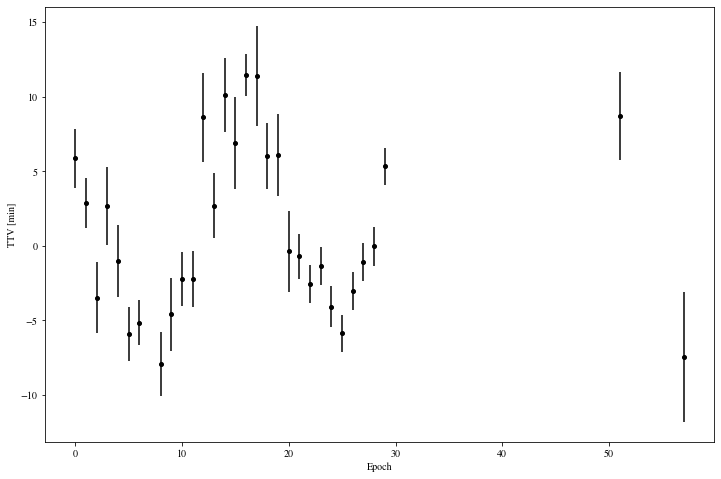

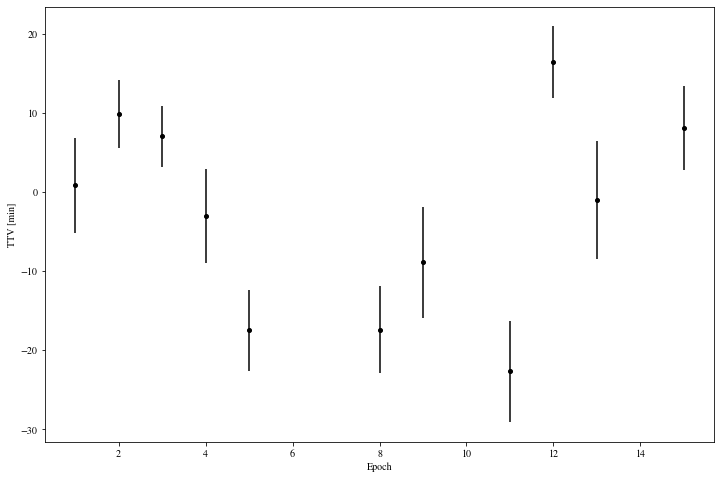

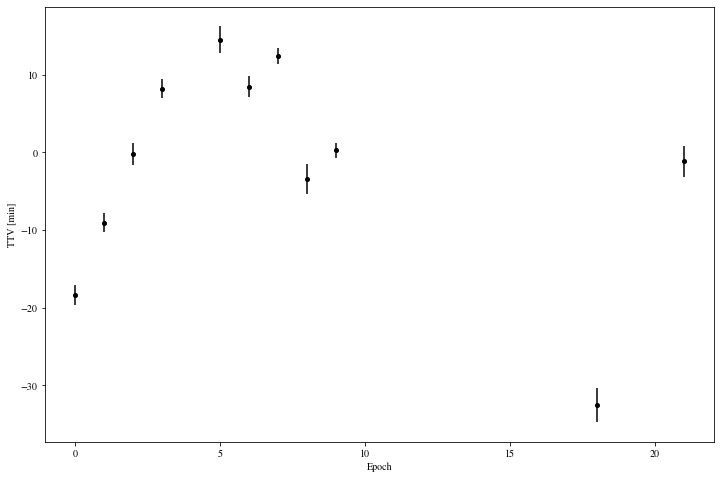

In [3]:
ttvnest.plot_utils.plot_ttv_data(kepler51)

Clear, anticorrelated signals! Now let's try to model it with ttvnest.

In [4]:
size = 4
with Pool(size) as executor:
    results = kepler51.retrieve(pool = executor, queue_size = size)

36144it [32:37,  2.58s/it, batch: 0 | bound: 0 | nc: 739 | ncall: 361026 | eff(%):  9.984 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010] /usr/local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
37337it [33:18, 30.18it/s, batch: 0 | bound: 11 | nc: 25 | ncall: 392518 | eff(%):  9.488 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.010]/usr/local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/usr/local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly

Let's see if we reproduce the results from Libby-Roberts et al. (2020):

In [5]:
kepler51.posterior_summary()
ttvnest.plot_utils.plot_results(kepler51, uncertainty_curves = 100, sim_length = 365.25*10, outname = 'kepler_51_parallel')

Summary (middle 95 percentile): 
$M_1/M_\star/3\times10^{-6}$: $5.227215^{+2.37266}_{-2.313988}$
$P_1\ [\mathrm{days}]$: $45.154336^{+0.000496}_{-0.000175}$
$\sqrt{e}_1\cos(\omega_1)$: $-0.105913^{+0.083384}_{-0.027976}$
$\sqrt{e}_1\sin(\omega_1)$: $-0.100796^{+0.045266}_{-0.050439}$
$T_{0,1}\ [\mathrm{days}]$: $2.110123^{+0.000964}_{-0.00083}$
$M_2/M_\star/3\times10^{-6}$: $4.727099^{+0.589972}_{-0.634683}$
$P_2\ [\mathrm{days}]$: $85.31681^{+0.002844}_{-0.002991}$
$\sqrt{e}_2\cos(\omega_2)$: $0.052245^{+0.02503}_{-0.091323}$
$\sqrt{e}_2\sin(\omega_2)$: $-0.038968^{+0.065169}_{-0.029758}$
$T_{0,2}\ [\mathrm{days}]$: $53.00747^{+0.004918}_{-0.004493}$
$M_3/M_\star/3\times10^{-6}$: $6.216251^{+1.887798}_{-1.639707}$
$P_3\ [\mathrm{days}]$: $130.192759^{+0.002458}_{-0.002536}$
$\sqrt{e}_3\cos(\omega_3)$: $-0.005655^{+0.044567}_{-0.061271}$
$\sqrt{e}_3\sin(\omega_3)$: $-0.029765^{+0.072797}_{-0.028185}$
$T_{0,3}\ [\mathrm{days}]$: $55.026515^{+0.00146}_{-0.001242}$


Looks alright! Let's make the suite of dynesty plots as well:

In [6]:
ttvnest.plot_utils.dynesty_plots(kepler51, outname = 'kepler_51_parallel')

['kepler_51_parallel_cornerplot.png',
 'kepler_51_parallel_traceplot.png',
 'kepler_51_parallel_runplot.png']

And let's save our work:

In [7]:
ttvnest.io_utils.save_results(kepler51, outname = 'kepler_51_parallel.p')

'kepler_51_parallel.p'